In [2]:
import torch
import numpy as np
from models.tokenizer import Tokenizer, Encoder, Decoder, EncoderDecoderConfig
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
config = EncoderDecoderConfig(
    resolution=64,
    in_channels=3,
    z_channels=512,
    ch=64,
    ch_mult=[1,1,1,1,1]   ,
    num_res_blocks=2,
    attn_resolutions=[8,16],
    out_ch=3,
    dropout=0.0
)

In [16]:
encoder = Encoder(config)
decoder = Decoder(config)
tokenizer = Tokenizer(vocab_size=512, embed_dim=512, encoder=encoder, decoder=decoder)

Tokenizer : shape of latent is (512, 4, 4).


/home/proger/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/proger/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
state_dict = {k[len("tokenizer."):]: v for k, v in torch.load('last.pt', map_location='cpu').items() if k.startswith('tokenizer.')}
tokenizer.load_state_dict(state_dict)

<All keys matched successfully>

In [48]:
frames = np.memmap('../image.bin', mode='r', dtype=np.uint8).reshape(-1, 64, 64, 3)

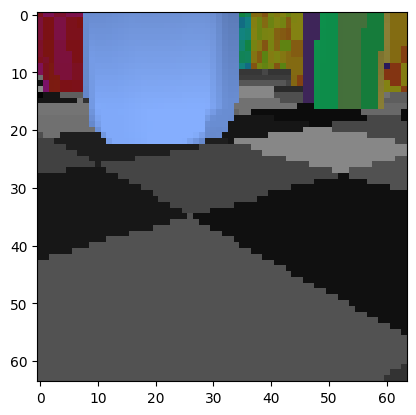

In [49]:
plt.imshow(frames[100])

tensor([[452, 297,  50, 438, 112, 331,   2, 430,  39, 471,  58, 476,  59, 501,
         358, 331]])

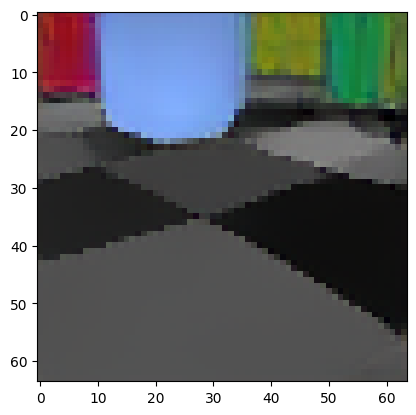

In [72]:
with torch.inference_mode():
    example = torch.tensor(frames[100]).unsqueeze(0).permute(0, 3, 1, 2) / 255.
    output = tokenizer.encode(example, should_preprocess=True)
    print('z_q', output.z_quantized.shape)
    reco = tokenizer.decode(output.z_quantized, should_postprocess=True)
plt.imshow(reco.permute(0, 2, 3, 1)[0].clamp(0,1))

output.tokens

In [126]:
batches = np.array_split(frames, len(frames)/128+1, axis=0)

In [134]:
token_lists = []
with torch.inference_mode():
    for i, batch in enumerate(tqdm(batches)):
        batch = torch.tensor(batch).permute(0, 3, 1, 2) / 255.
        batch = batch.to('cuda:0')
        output = tokenizer.encode(batch, should_preprocess=True)
        token_lists.append(output.tokens.cpu().numpy())

100%|██████████| 23803/23803 [11:27<00:00, 34.60it/s]


In [137]:
all_tokens = np.memmap('../tokens.bin', dtype=np.uint16, mode='w+', shape=(len(frames), 16))
all_tokens[:, :] = np.concatenate(token_lists, axis=0)
all_tokens.flush()

In [46]:
twist_codes = np.array([[0,0], [5,0], [0, -2.5], [0,2.5]]) # stop forward left right
twists = np.memmap('../twist.bin', dtype=np.float64, mode='r', shape=(3046772,2))
twistq = np.argmin(np.linalg.norm(twists[None,:,:] - twist_codes[:,None,:], axis=2), axis=0)

twistq

array([0, 2, 2, ..., 1, 1, 1])

In [70]:
all_tokens = np.memmap('../tokens.bin', dtype=np.uint16, mode='r', shape=(3046772, 16))
twistframes = np.concatenate([twistq[:,None]+1, all_tokens + 5], axis=1).reshape(-1).astype(np.uint16)


twistframes.tofile('../twistframes.bin')
twistframes.shape

(51795124,)

In [73]:
(16+1)*16

272

In [71]:
twistframes.max()

516